# RWによる同心円の容量計算  テスト２
開始点をランダムに決定
RW毎に電荷への寄与度を計算し累積したものをRW数で割ることで統計的に容量を算出する。

100%|██████████| 320/320 [00:12<00:00, 26.12it/s]



=== Calculation Results ===
Calculated Capacitance : 5.075e-11 F/m
Theoretical Capacitance: 5.064e-11 F/m
Relative Error        : 0.21%
Inner Hit Probability : 0.957
Charge contribution   : 1.168e-09 C/hit
Average Steps per Walk: 93.6
Total Random Walks    : 32000
Computation Time      : 12.25 seconds



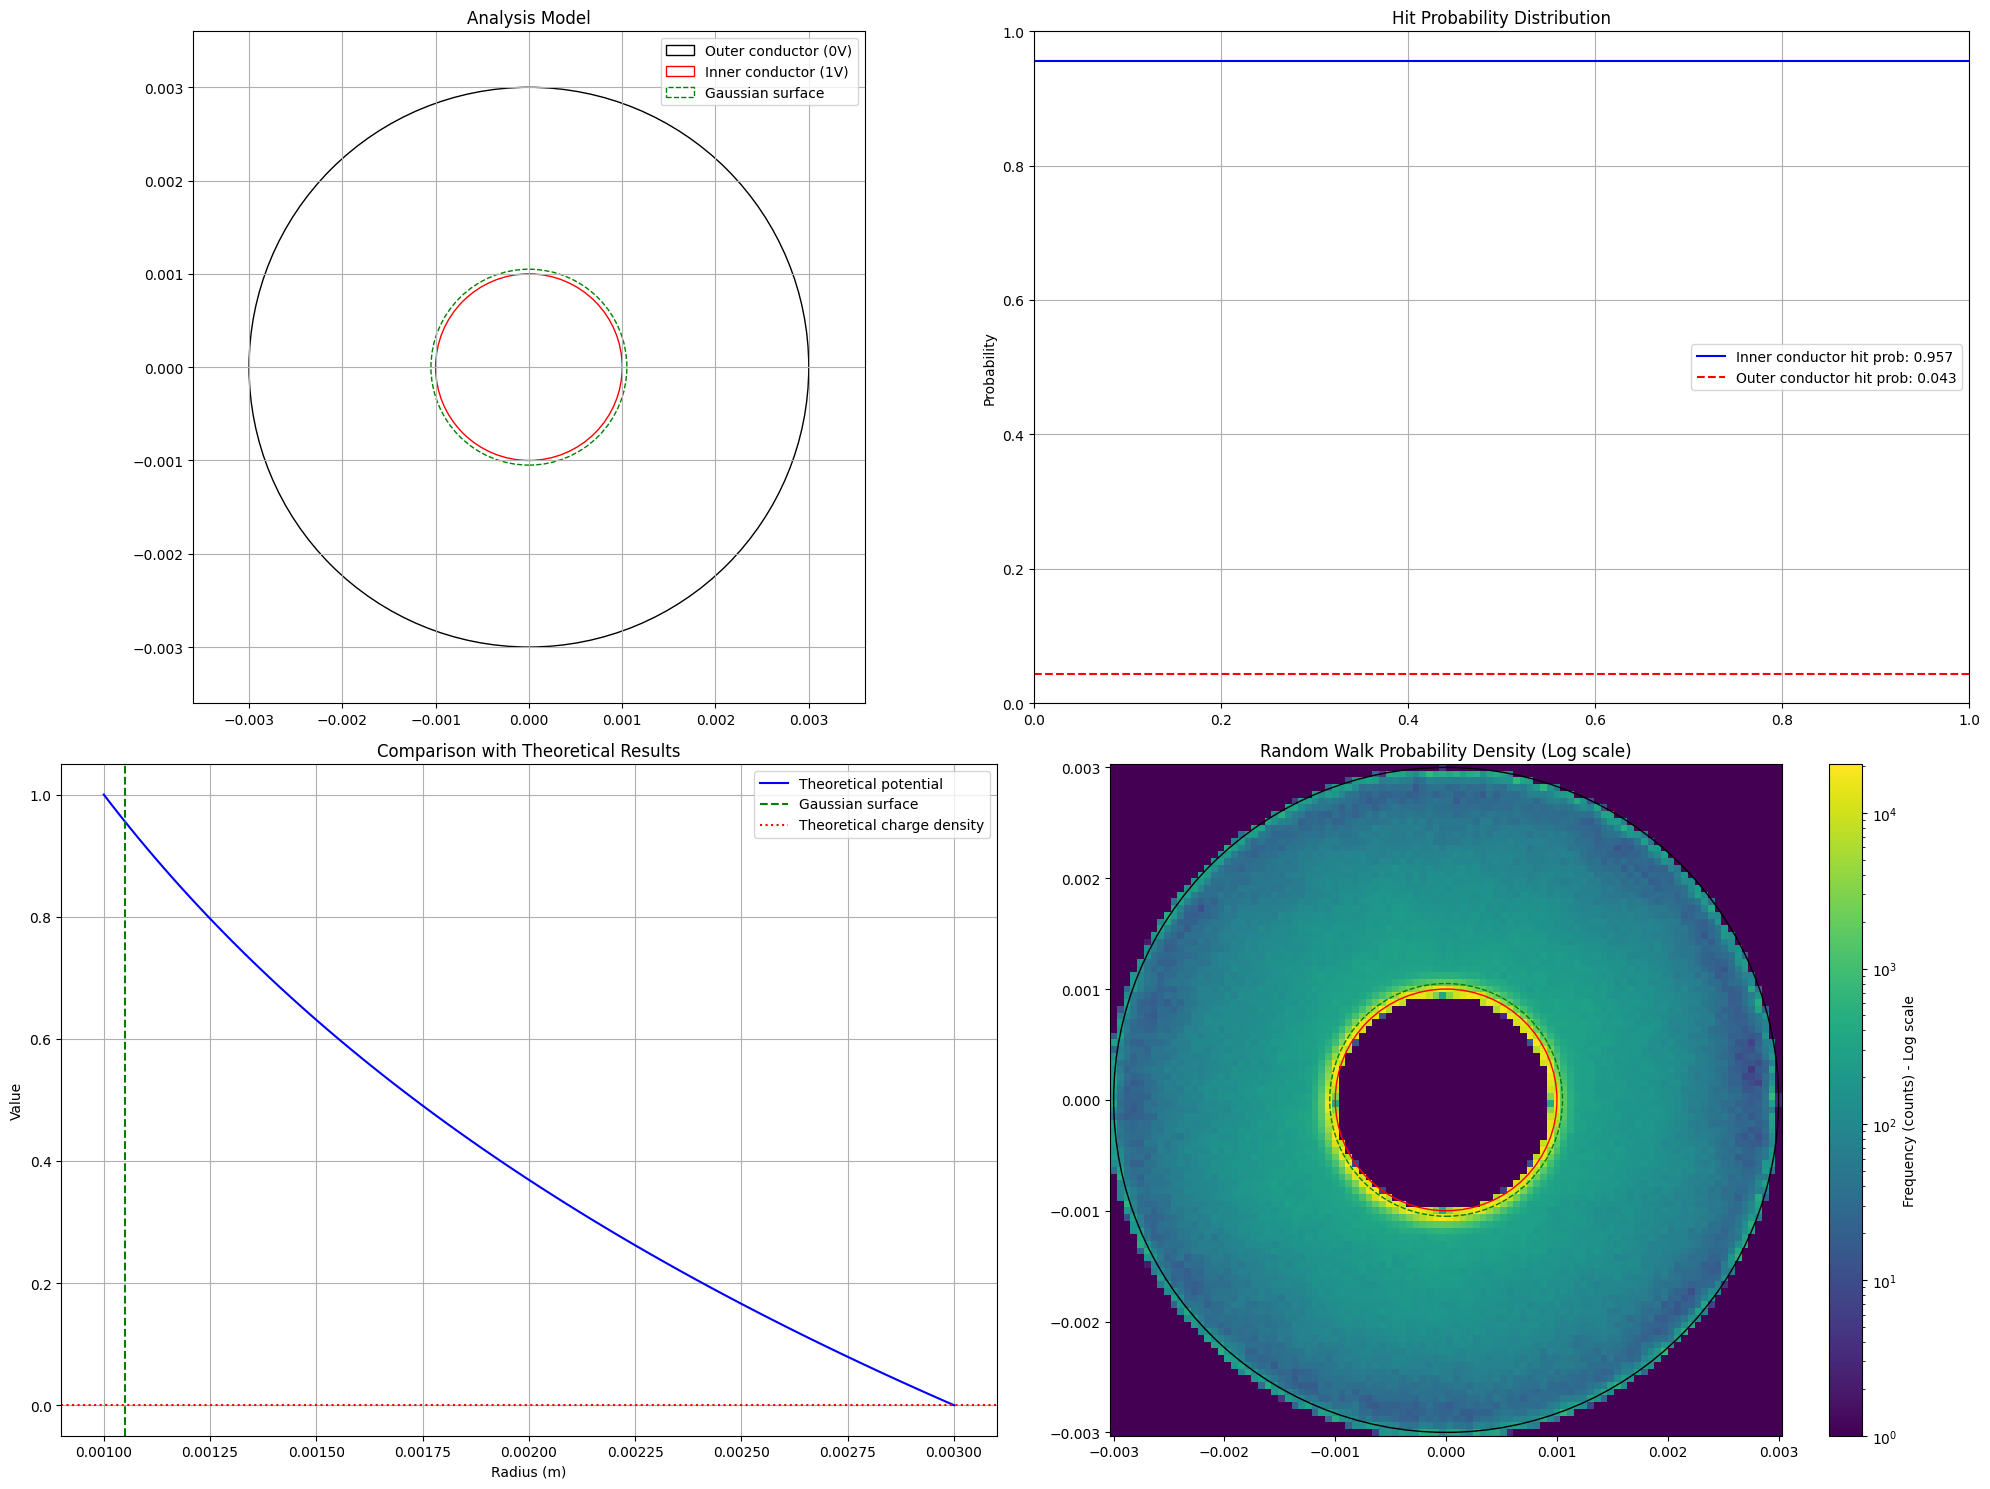

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
from tqdm import tqdm
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
import time

class CapacitanceCalculator:
    """同心円形状の容量計算クラス - 1回のRWごとの電荷寄与を計算"""
    
    def __init__(
        self,
        inner_radius: float,
        outer_radius: float,
        gaussian_surface_ratio: float,
        num_walks: int,
        base_step_size: float,
        mesh_size: int = 50,
        batch_size: int = 100
    ):
        self.inner_radius = inner_radius
        self.outer_radius = outer_radius
        self.gaussian_radius = inner_radius * gaussian_surface_ratio
        self.num_walks = num_walks
        self.base_step_size = base_step_size
        self.epsilon0 = 8.854e-12
        self.batch_size = batch_size
        
        # メッシュの設定
        self.mesh_size = mesh_size
        self.x_mesh = np.linspace(-outer_radius, outer_radius, mesh_size)
        self.y_mesh = np.linspace(-outer_radius, outer_radius, mesh_size)
        self.density_map = np.zeros((mesh_size, mesh_size))
        self.mesh_scale = (mesh_size - 1) / (2 * outer_radius)
        self.total_steps = 0

        # 基本的な前計算
        self.r2_inner = self.inner_radius ** 2
        self.r2_outer = self.outer_radius ** 2
        
        # 電荷寄与度の計算に必要な定数を前計算
        self.d = self.gaussian_radius - self.inner_radius  # ガウス面までの距離
        self.gaussian_circumference = 2 * np.pi * self.gaussian_radius  # ガウス面の全周長
        self.charge_factor = self.epsilon0 * self.gaussian_circumference / self.d  # マイナス符号を削除
        
    def generate_random_start_point(self) -> np.ndarray:
        """ガウス面上のランダムな開始点を1つ生成"""
        theta = np.random.uniform(0, 2*np.pi)
        return self.gaussian_radius * np.array([np.cos(theta), np.sin(theta)])

    def update_density_map(self, positions: np.ndarray):
        """密度マップの更新"""
        indices_x = ((positions[:, 0] + self.outer_radius) * self.mesh_scale).astype(int)
        indices_y = ((positions[:, 1] + self.outer_radius) * self.mesh_scale).astype(int)
        
        mask = (indices_x >= 0) & (indices_x < self.mesh_size) & \
               (indices_y >= 0) & (indices_y < self.mesh_size)
        
        for x, y in zip(indices_x[mask], indices_y[mask]):
            self.density_map[y, x] += 1

    def random_walk_batch(self) -> Tuple[np.ndarray, int]:
        """バッチ処理によるランダムウォーク（ランダムな開始点）
        Returns:
            hit_results: 各ウォークの結果 (1: 内円ヒット, 0: 外円ヒット)
            total_steps: 総ステップ数
        """
        # バッチ内の各ウォークに対して個別の開始点を生成
        start_points = np.array([self.generate_random_start_point() for _ in range(self.batch_size)])
        positions = start_points.copy()
        total_steps = 0
        active = np.ones(self.batch_size, dtype=bool)
        hit_results = np.zeros(self.batch_size, dtype=int)  # 1: 内円ヒット, 0: 外円ヒット
        
        while active.any():
            n_active = active.sum()
            
            # 適応的なステップサイズの計算
            r = np.sqrt(np.sum(positions[active]**2, axis=1))
            dist_inner = np.abs(r - self.inner_radius)
            dist_outer = np.abs(r - self.outer_radius)
            min_dist = np.minimum(dist_inner, dist_outer)
            
            base_step = self.base_step_size * (self.outer_radius - self.inner_radius)
            boundary_step = min_dist * 0.5
            step_sizes = np.minimum(base_step, boundary_step)
            step_sizes = np.maximum(step_sizes, 1e-6)
            
            # ランダムな方向への移動
            angles = np.random.uniform(0, 2*np.pi, n_active)
            moves = np.column_stack((
                step_sizes * np.cos(angles),
                step_sizes * np.sin(angles)
            ))
            
            positions[active] += moves
            self.update_density_map(positions[active])
            
            # 終了判定
            r2 = np.sum(positions[active]**2, axis=1)
            inner_hit = r2 <= self.r2_inner
            outer_hit = r2 >= self.r2_outer
            
            active_indices = np.where(active)[0]
            
            # ヒット結果を記録
            hit_results[active_indices[inner_hit]] = 1  # 内円ヒット
            
            active[active_indices[inner_hit | outer_hit]] = False
            total_steps += n_active

        return hit_results, total_steps

    def calculate_capacitance(self) -> Tuple[float, Dict]:
        """容量を計算"""
        start_time = time.time()
        self.density_map.fill(0)
        self.total_steps = 0
        
        total_charge = 0  # 総電荷を蓄積
        all_hit_results = []  # すべてのヒット結果を保存
        
        # バッチ処理でランダムウォークを実行
        for batch in tqdm(range(0, self.num_walks, self.batch_size)):
            batch_size = min(self.batch_size, self.num_walks - batch)
            
            if batch_size != self.batch_size:
                temp_batch_size = self.batch_size
                self.batch_size = batch_size
                hit_results, steps = self.random_walk_batch()
                self.batch_size = temp_batch_size
            else:
                hit_results, steps = self.random_walk_batch()
            
            # 電荷への寄与を計算
            # 内円ヒット(hit_results=1)の場合は寄与0
            # 外円ヒット(hit_results=0)の場合はcharge_factorを加算
            batch_charge = np.sum(~hit_results.astype(bool)) * self.charge_factor
            total_charge += batch_charge
            
            all_hit_results.extend(hit_results)
            self.total_steps += steps
        
        # 平均電荷を計算（=容量）
        C = total_charge / self.num_walks
        
        # 理論値の計算
        C_theoretical = 2 * np.pi * self.epsilon0 / np.log(self.outer_radius / self.inner_radius)
        
        computation_time = time.time() - start_time
        
        results = {
            'hit_results': np.array(all_hit_results),
            'inner_hit_probability': np.mean(all_hit_results),
            'theoretical_capacitance': C_theoretical,
            'relative_error': abs(C - C_theoretical) / C_theoretical * 100,
            'density_map': self.density_map,
            'max_frequency': np.max(self.density_map),
            'average_steps': self.total_steps / self.num_walks,
            'computation_time': computation_time,
            'charge_contribution': self.charge_factor  # 1回の外円ヒットあたりの電荷寄与
        }

        return C, results

    def plot_all_results(self, results: Dict):
        """結果の可視化"""
        fig = plt.figure(figsize=(20, 15))
        
        # 1. 解析モデル図
        ax1 = fig.add_subplot(221)
        self._plot_model(ax1)
        
        # 2. ヒット確率の分布
        ax2 = fig.add_subplot(222)
        self._plot_hit_probability(ax2, results)
        
        # 3. 理論値との比較
        ax3 = fig.add_subplot(223)
        self._plot_theoretical_comparison(ax3, results)
        
        # 4. ランダムウォーク密度分布
        ax4 = fig.add_subplot(224)
        self._plot_walk_density(ax4, results)
        
        plt.tight_layout()
        plt.show()

    def _plot_model(self, ax):
        """解析モデル図の描画"""
        outer = Circle((0, 0), self.outer_radius, fill=False, color='black', label='Outer conductor (0V)')
        inner = Circle((0, 0), self.inner_radius, fill=False, color='red', label='Inner conductor (1V)')
        gaussian = Circle((0, 0), self.gaussian_radius, fill=False, color='green', linestyle='--', 
                        label='Gaussian surface')
        
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.add_patch(gaussian)
        
        ax.set_aspect('equal')
        ax.grid(True)
        ax.legend()
        ax.set_title('Analysis Model')
        
        margin = 0.2
        ax.set_xlim(-self.outer_radius*(1+margin), self.outer_radius*(1+margin))
        ax.set_ylim(-self.outer_radius*(1+margin), self.outer_radius*(1+margin))

    def _plot_hit_probability(self, ax, results):
        """ヒット確率分布のプロット"""
        ax.axhline(y=results['inner_hit_probability'], color='blue', linestyle='-', 
                  label=f'Inner conductor hit prob: {results["inner_hit_probability"]:.3f}')
        ax.axhline(y=1-results['inner_hit_probability'], color='red', linestyle='--', 
                  label=f'Outer conductor hit prob: {1-results["inner_hit_probability"]:.3f}')
        
        ax.set_title('Hit Probability Distribution')
        ax.set_ylabel('Probability')
        ax.grid(True)
        ax.legend()

    def _plot_theoretical_comparison(self, ax, results):
        """理論値との比較プロット"""
        # 理論的な電位分布
        r = np.linspace(self.inner_radius, self.outer_radius, 100)
        V_theoretical = 1.0 - np.log(r/self.inner_radius) / np.log(self.outer_radius/self.inner_radius)
        
        ax.plot(r, V_theoretical, 'b-', label='Theoretical potential')
        ax.axvline(x=self.gaussian_radius, color='g', linestyle='--', label='Gaussian surface')
        
        C = results['theoretical_capacitance']
        charge = C  # V=1なので、Q=CV=C
        charge_density_theoretical = charge / (2 * np.pi * self.gaussian_radius)
        ax.axhline(y=charge_density_theoretical, color='r', linestyle=':', 
                  label='Theoretical charge density')
        
        ax.set_title('Comparison with Theoretical Results')
        ax.set_xlabel('Radius (m)')
        ax.set_ylabel('Value')
        ax.grid(True)
        ax.legend()

    def _plot_walk_density(self, ax, results):
        """対数スケールでのランダムウォーク確率密度分布プロット"""
        min_nonzero = np.min(results['density_map'][results['density_map'] > 0])
        plot_data = results['density_map'].copy()
        plot_data[plot_data == 0] = min_nonzero / 2
        
        im = ax.pcolormesh(self.x_mesh, self.y_mesh, plot_data,
                          norm=LogNorm(vmin=min_nonzero, vmax=np.max(plot_data)),
                          cmap='viridis')
        
        outer = Circle((0, 0), self.outer_radius, fill=False, color='black')
        inner = Circle((0, 0), self.inner_radius, fill=False, color='red')
        gaussian = Circle((0, 0), self.gaussian_radius, fill=False, color='green', 
                        linestyle='--')
        
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.add_patch(gaussian)
        
        plt.colorbar(im, ax=ax, label='Frequency (counts) - Log scale')
        
        ax.set_aspect('equal')
        ax.set_title('Random Walk Probability Density (Log scale)')

# 使用例
if __name__ == "__main__":
    # パラメータ設定
    params = {
        'inner_radius': 0.001,        # 内円半径 [m]
        'outer_radius': 0.003,        # 外円半径 [m]
        'gaussian_surface_ratio': 1.05, # ガウス面の位置（内円半径との比）
        'num_walks': 32000,           # 総ランダムウォーク回数
        'base_step_size': 1/20,       # 基本ステップサイズ
        'mesh_size': 100,             # メッシュサイズ
        'batch_size': 100             # バッチサイズ
    }

    # 計算実行
    calculator = CapacitanceCalculator(**params)
    C, results = calculator.calculate_capacitance()

    

    # 結果表示
    print("\n=== Calculation Results ===")
    print(f"Calculated Capacitance : {C:.3e} F/m")
    print(f"Theoretical Capacitance: {results['theoretical_capacitance']:.3e} F/m")
    print(f"Relative Error        : {results['relative_error']:.2f}%")
    print(f"Inner Hit Probability : {results['inner_hit_probability']:.3f}")
    print(f"Charge contribution   : {results['charge_contribution']:.3e} C/hit")
    print(f"Average Steps per Walk: {results['average_steps']:.1f}")
    print(f"Total Random Walks    : {params['num_walks']}")
    print(f"Computation Time      : {results['computation_time']:.2f} seconds")
    print("==========================\n")

    # 結果のプロット
    calculator.plot_all_results(results)
    

確率が均一になり、開始点をランダムで取るほうが良いことが分かる。